In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [4]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("train_proteins.csv")
train_peptides = pd.read_csv("train_peptides.csv")
train_clinical = pd.read_csv("train_clinical_data.csv")

In [5]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [6]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

In [7]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

In [8]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

In [9]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [12]:
mse_list = []
sMAPE_list = []

In [13]:
# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label   
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    # replace other null value with mean of col
    #col_means = round(dataset_df.mean(),1)
    #dataset_filled = dataset_df.fillna(col_means)
    dataset_filled = dataset_df.fillna(0)
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy() 
    feature_list.append(label)

    feature_l = [i for i in feature_list if i not in target]

    # Split the dataset into train and validation datasets.
    X_train, X_test, y_train, y_test = train_test_split(dataset_filled[feature_l], dataset_filled[label], test_size=0.2, random_state=27)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(max_iter=5000, solver='sag', multi_class='multinomial',C=3)
    
    model.fit(X_train_scaled,y_train)

    #y_pred = model.predict(X_test)
    y_pred = model.predict(X_test_scaled)
    model_dict[label] = [y_pred,y_test]
    mse = mean_squared_error(y_test,y_pred)
    #r2 = r2_score(y_test,y_pred)
    sMAPE = smape(y_pred,y_test)
    mse_list.append(mse)
    sMAPE_list.append(sMAPE)
    print(f'{label} mse: {mse}      sMAPE: {sMAPE}')

updrs_1 mse: 39.52336448598131      sMAPE: 81.32051331912982
updrs_2 mse: 42.58878504672897      sMAPE: 81.47143911965395
updrs_3 mse: 219.4245283018868      sMAPE: 80.34267823898556
updrs_4 mse: 10.74561403508772      sMAPE: 67.80485304169515


In [18]:
print(f'average mse is {np.mean(mse_list)}')
print(f'average sMAPE is {np.mean(sMAPE_list)}')


average mse is 77.86805136629265
average sMAPE is 77.74341218902534


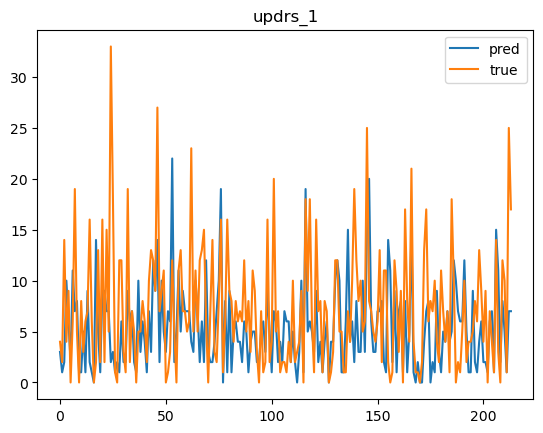

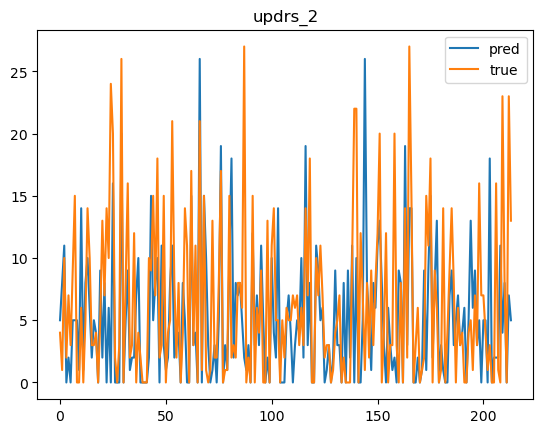

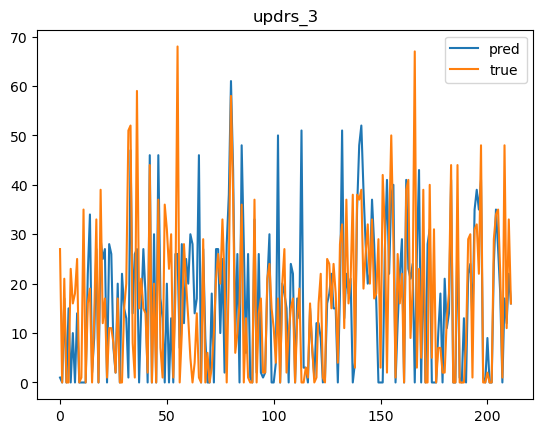

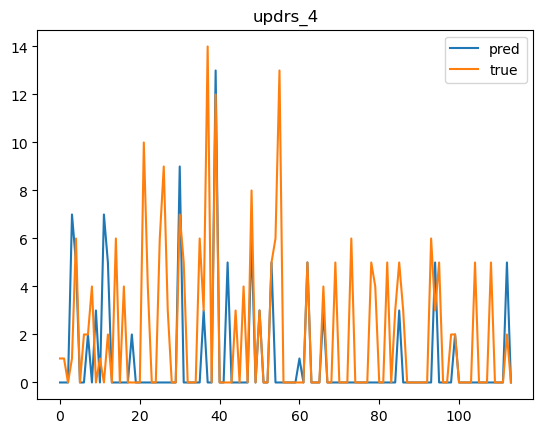

In [21]:
for key,value in model_dict.items():
    y_pred = value[0]
    y_test = value[1]
    x = len(y_pred)
    xx = np.array(range(x))
    fig,ax = plt.subplots(1,1)
    ax.plot(xx,y_pred,label='pred')
    ax.plot(xx,y_test,label='true')
    ax.set_title(f'{key}')
    ax.legend()